# Keras - simulated NMR data
### Paul Giesting

##### Summary of my work this week
1. I explored the baseline PyTorch implementation and calculated a version of the custom error metric we'll be graded on, about 0.17 per row of input data.
1. I tried to implement a Keras version of the PyTorch baseline model, but the PyTorch syntax is completely unfamiliar to me and I cannot be sure I'm really getting all that close. The error by the same metric was 0.24.
1. I did some EDA on the dataset and remarked how unrelated the xi, p, and d properties seemed to be to the values of the M curve at the 180 and echo points.
1. I used the autosklearn library and manual exploration to see if non-neural-network solutions could get any traction. The answer was "not really, not in the time alloted" (and I alloted a lot of Tuesday, all of Wednesday, and Thursday until 5 pm, more than made sense). At one point I encountered a k-nearest-neighbors regression via autosklearn that could reproduce some of the alpha behavior but even that was remarkably easy to lose. I cannot reproduce it manually. I noted that random forest and extra tree models at close to baseline configurations would horrendously overtrain (stuff like 0.08 training error and 0.52 test error).
1. I deployed autokeras. I tried implementing the custom error function as the loss and/or metric function in autokeras and while the model would train, it would then refuse to export the structure or compute predictions. I went back to the default loss and metric settings after training with the custom metric, trained again hoping that some of the learned weights would influence the outcome, but I doubt they did. The best I was able to find was a simple-ish model that got down to 0.22 error.
1. Today I produced the contents of this notebook. I saved the results of model 5, the best model in terms of performance, only insofar as they are seen in the output below; I redid model 5 as model 13, with a different draw of train / test data and different results on the stochastic descent, etc. Model 13 was used to produce my output submission; the cell where the data was exported is near the top, before model construction begins.

##### Description of another team's approach
"Our solution, called VisEcho, was a fully convolutional network, with depthwise separable convolutions replacing the need for fully connected layers. If anyone is interested, they can check it out at my GitHub account here: https://github.com/stephenhgregory/VisEcho " [actually there is no information there]

In [1]:
import keras.backend as K
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Input, Concatenate
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
import kerastuner

In [2]:
from keras.losses import MeanSquaredError
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow import math as tfmath

In [4]:
# mean version of gross error metric

def weight_mse(truth,predict):
    erf = 0.0
    weight = [0.2, 20, 2, 3]
    for col in range(4):
        erf += sklearn.metrics.mean_squared_error(truth[:,col],predict[:,col]) / (weight[col]**2)
    return erf

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos
print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);
# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")

Loading into numpy arrays...
Done with numpy loads


In [6]:
# partition data into a training and testing set using a random partition
# number of M(t) curves
N_data = np.shape(M)[0]

# pick a 90%/10% split for training/testing
test_frac = 0.10                                # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data)      # random ordering for all curves

train_idx = order_seed[0:div_idx]               # first 90% of random order
test_idx = order_seed[div_idx:N_data]           # last 10% of random order

In [7]:
# truncate time points from 210 to 410 in example
# centered roughly at the echo
# let's use whole experiment now
time_keep = range(0,157*3);

# concatenate the real and imaginary parts together, to make a real-vector of double the length
M_train = M[train_idx[:,None],time_keep]                    # time truncation of input
mat_train = mat_info[train_idx,:]                           # get the output
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part
# is this equivalent to
# M_train = np.hstack(M_r[train_idx],M_i[train_idx])
# ?

# same as above, but for test
M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
M_test = np.hstack( (np.real(M_test), np.imag(M_test)) )

In [8]:
N = np.shape(M_train[0])[0]

In [9]:
# scale the material properties consistently
# so that mean squared error is the appropriate metric
scaler = MinMaxScaler()
scaler.fit(mat_info)

MinMaxScaler()

In [10]:
# data for submission of final model
sub_file_r = "submit_echos_r.txt"
sub_file_i = "submit_echos_i.txt"

In [86]:
# for competition submission only
import requests

r = requests.get("https://docs.google.com/uc?export=download&id=14-oz_3OGsTFziJI1FUg0EenMcdQDf2F_",allow_redirects=True)
open(sub_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1Add2V9cYOBbOCvr1Dj-g4yMlx3LdJY8i",allow_redirects=True)
open(sub_file_i, "wb").write(r.content)

print("Done with file downloads")

Done with file downloads


In [11]:
# for competition submission only
# M(t) curve for each simulation:
M_r_sub = np.loadtxt(sub_file_r, comments="#", delimiter='\t', unpack=False);
M_i_sub = np.loadtxt(sub_file_i, comments="#", delimiter='\t', unpack=False);
M_cmplx_sub = M_r_sub + 1j*M_i_sub;
M_sub = np.hstack( (np.real(M_cmplx_sub), np.imag(M_cmplx_sub)) ) # real part, then imaginary part
print("Done with numpy loads")

Done with numpy loads


In [16]:
# for competition submission only
mat_sub = scaler.inverse_transform(model13.predict(M_sub))
print(mat_sub[:5,:])
sub_file = "submitted_mat_info.txt"
np.savetxt(sub_file,mat_sub,fmt='%10.8f',delimiter='\t',header='Paul Giesting NMR submission')

[[1.9445598e-01 9.7248974e+00 2.4649928e+00 4.1607680e+00]
 [2.6868028e-03 1.0338113e+01 2.9087524e+00 4.9438171e+00]
 [5.7800967e-02 1.0118806e+01 3.2239895e+00 4.5901608e+00]
 [5.3764884e-03 9.9226151e+00 3.1163795e+00 3.7858155e+00]
 [1.3918748e-01 1.0627731e+01 3.5263150e+00 4.6521125e+00]]


In [17]:
# for competition submission only
check = np.loadtxt(sub_file, comments="#", delimiter='\t', unpack=False)
len(check)

500

## Preface

This is the description of the best autokeras model, exported to keras. I have no idea why autokeras inserted a category encoding layer. Since the input data are restricted to -0.5 to 0.5, I don't think a normalization layer is likely to be needed, but it's an option that could be tried later on. If I do that, it looks like I should `adapt` the layer to the training data, or possibly the whole training+validation set, before fitting the whole model.

Ok, step 1: see if I can reproduce the autokeras model without the encoding layer.

## Model 1

In [ ]:
model_description = \
'''Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                28832     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 4)                 132       
=================================================================
Total params: 30,020
Trainable params: 30,020
Non-trainable params: 0
_________________________________________________________________'''

In [14]:
input_layer = Input(shape=(N,))
layer1 = Dense(32,activation='relu')(input_layer)
layer2 = Dense(32,activation='relu')(layer1)
layer3 = Dense(4)(layer2)

model = Model(inputs=input_layer, outputs=layer3)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                28832     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 30,020
Trainable params: 30,020
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 'huber_loss' is what I was using to construct the keras analog to PyTorch
# it is not autokeras' default, which was val_loss for one or both
# of the loss function and metric (mse was reported too)
# can't even find that here? yet it should be the default?
# vanilla keras won't take the custom loss metric either
opt = keras.optimizers.SGD(learning_rate=0.005,momentum=0.9)
model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [35]:
# number of epochs and batches
# 20 epochs was still dropping the metrics on autokeras
# can't tell from PyTorch OR autokeras what their what the batch size was
# batch size 10 worked a little better than 20, which was somewhat better
# than 50 in my earlier keras exploration
n_epochs = 40
n_batch = 10
# transform the target so that mse is equivalent to the appropriate metric
print('Starting Training')
model.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 2/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 3/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 4/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 5/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 6/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0480 - mean_squared_error: 0.0480
Epoch 7/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0474 - mean_squared_error: 0.0474
Epoch 8/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 9/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0462 - mean_squared_error:

In [36]:
mat_train_predict = scaler.inverse_transform(model.predict(M_train,batch_size=n_batch))
mat_predict = scaler.inverse_transform(model.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat_train_predict))
print('Test score for model ',weight_mse(mat_test,mat_predict))

Training score for model  0.14181771689758704
Test score for model  0.13789912161340212


That seems to have done something. Egads. Let's plot that.

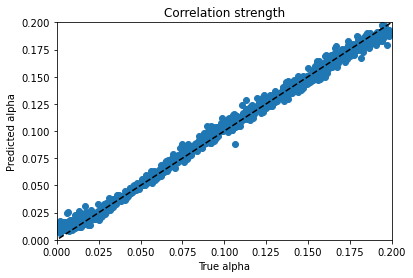

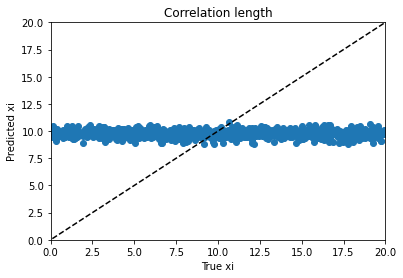

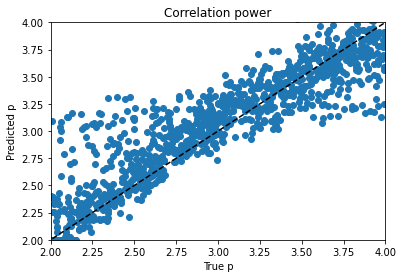

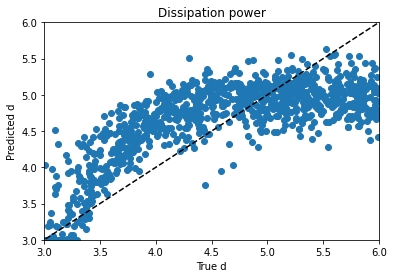

In [37]:
plt.scatter(mat_test[:,0],mat_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

It's late Friday morning and my model is ALMOST to the point of the baseline. Whatever. We barely grazed deep learning in my bootcamp and I didn't engage with it seriously prior to this week.

(I then went back and increased learning rate from 0.001 to 0.005 and ran for 40 epochs. Now it's an actual improvement!)

Then let's try normalizing the targets instead of compressing them to [0,1].

## Model 2

In [30]:
input2_layer = Input(shape=(N,))
layer21 = Dense(32,activation='relu')(input2_layer)
layer22 = Dense(32,activation='relu')(layer21)
layer23 = Dense(4)(layer22)

model2 = Model(inputs=input2_layer, outputs=layer23)
model2.summary()

Model: "functional_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                28832     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 30,020
Trainable params: 30,020
Non-trainable params: 0
_________________________________________________________________


In [31]:
# scale the material properties consistently
normer = StandardScaler()
normer.fit(mat_info)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
opt = keras.optimizers.SGD(learning_rate=0.005,momentum=0.9)
model2.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [39]:
# number of epochs and batches
n_epochs = 40
n_batch = 10
# transform the target; mse is not quite the appropriate metric now but still close
print('Starting Training')
model2.fit(M_train,normer.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 1s 2ms/step - loss: 0.5640 - mean_squared_error: 0.5640
Epoch 2/40
900/900 [==============================] - 1s 1ms/step - loss: 0.5415 - mean_squared_error: 0.5415
Epoch 3/40
900/900 [==============================] - 1s 1ms/step - loss: 0.5211 - mean_squared_error: 0.5211
Epoch 4/40
900/900 [==============================] - 1s 2ms/step - loss: 0.5076 - mean_squared_error: 0.5076
Epoch 5/40
900/900 [==============================] - 1s 2ms/step - loss: 0.5008 - mean_squared_error: 0.5008
Epoch 6/40
900/900 [==============================] - 1s 1ms/step - loss: 0.4965 - mean_squared_error: 0.4965
Epoch 7/40
900/900 [==============================] - 1s 2ms/step - loss: 0.4850 - mean_squared_error: 0.4850
Epoch 8/40
900/900 [==============================] - 1s 2ms/step - loss: 0.4772 - mean_squared_error: 0.4772
Epoch 9/40
900/900 [==============================] - 1s 2ms/step - loss: 0.4732 - mean_squared_error:

In [40]:
mat2_train_predict = normer.inverse_transform(model2.predict(M_train,batch_size=n_batch))
mat2_predict = normer.inverse_transform(model2.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat2_train_predict))
print('Test score for model ',weight_mse(mat_test,mat2_predict))

Training score for model  0.16133084616711393
Test score for model  0.15742218232789149


Let's plot that.

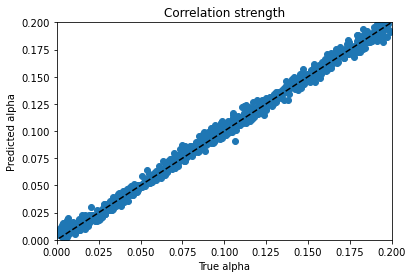

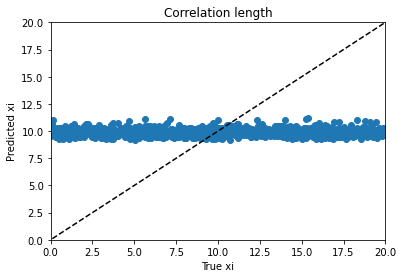

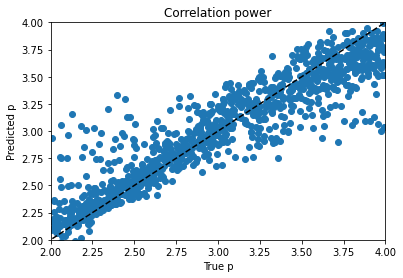

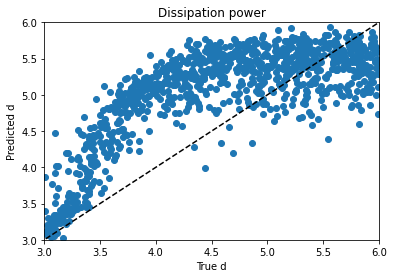

In [41]:
plt.scatter(mat_test[:,0],mat2_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat2_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat2_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat2_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Fascinating and weird.

I could introduce some dropout to regularize features.

Another step would be to introduce an RNN layer as we saw at Metis.

Also worth checking using only Im(M) for input.

Obviously I could also tinker with the width of layers and number of layers.

Keras has the Tuner to fit structure and hyperparameters, too. Let's go back and follow that methodology.

## Model 3

In [98]:
def build_model(hp):
    inputs = Input(shape=(N,))
    x = Dense(
        units = hp.Int('units1',min_value=32,max_value=512,step=32),
        activation='relu'
    )(inputs)
    y = Dense(
        units = hp.Int('units2',min_value=16,max_value=128,step=16),
        activation='relu'
    )(x)
    outputs = Dense(4)(y)
    model = Model(inputs, outputs)
    opt = keras.optimizers.SGD(
        hp.Choice('learning_rate',
                 values=[0.01,0.005,0.001]),
        hp.Choice('momentum',
                 values=[0.67,0.9,0.95])
    )
    model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
    return model

In [96]:
tuner = kerastuner.tuners.Hyperband(
        build_model,
        objective='mean_squared_error',
        max_epochs=100,
        executions_per_trial=2,
        directory='keras_tune'
)

INFO:tensorflow:Reloading Oracle from existing project keras_tune/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from keras_tune/untitled_project/tuner0.json


In [97]:
print('Starting Tuning')
tuner.search(M_train,scaler.transform(mat_train),
             validation_data=(M_test,mat_test))
print('Finished Tuning')

Trial 3 Complete [00h 00m 16s]
mean_squared_error: 0.052428992465138435

Best mean_squared_error So Far: 0.03339175321161747
Total elapsed time: 00h 00m 50s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
units             |416               |512               
learning_rate     |0.001             |0.01              
momentum          |0.95              |0.95              
tuner/epochs      |4                 |100               
tuner/initial_e...|0                 |34                
tuner/bracket     |3                 |4                 
tuner/round       |0                 |4                 

Epoch 1/4
282/282 [==============================] - 2s 8ms/step - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 37.1822 - val_mean_squared_error: 37.1822
Epoch 2/4
282/282 [==============================] - 2s 7ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 37.1349 - val_mean_squared_error: 37.1349
Epoch 3/4
282/282 [==============

KeyboardInterrupt: 

Tuner is using a much larger batch size than I was and probably that's why it's taking it so much effort to get the same loss as I got with a weakly optimized model from autokeras. I can redo that model manually, or dig into the tuner docs (such as any docs are these days) to see if I can specify batch size in the search method (since it gets specified in the fit method).

The best model (480 nodes on layer x) is now bouncing around in the 0.034 range. 100 epochs is probably more than helpful.

In [99]:
tuner.results_summary()

Results summary
Results in keras_tune/untitled_project
Showing 10 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
momentum: 0.95
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 16d525137b29d2fb93bb6895b7584b14
Score: 0.03339175321161747
Trial summary
Hyperparameters:
units: 480
learning_rate: 0.01
momentum: 0.95
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 9ae48accc072e172da3ee0269e5e1af3
Score: 0.03342658281326294
Trial summary
Hyperparameters:
units: 480
learning_rate: 0.01
momentum: 0.95
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: b2f2dabda9a3790faa3a0346ba88fbe8
Score: 0.03837982751429081
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
momentum: 0.95
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: fd1fc8699ec897f87f15ff

In [100]:
tuned_models = tuner.get_best_models(num_models=2)

In [101]:
print(tuned_models[0].summary(),tuned_models[1].summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               461312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 726,020
Trainable params: 726,020
Non-trainable params: 0
_________________________________________________________________
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
__________________________

In [102]:
model3 = tuned_models[0]
#opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
#model3.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
n_epochs = 40
n_batch = 10
# transform the target so that mse is equivalent to the appropriate metric
print('Starting Training')
model3.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 6s 6ms/step - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 2/40
900/900 [==============================] - 6s 7ms/step - loss: 0.0377 - mean_squared_error: 0.0377
Epoch 3/40
900/900 [==============================] - 6s 6ms/step - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 4/40
900/900 [==============================] - 7s 7ms/step - loss: 0.0366 - mean_squared_error: 0.0366
Epoch 5/40
900/900 [==============================] - 6s 7ms/step - loss: 0.0372 - mean_squared_error: 0.0372
Epoch 6/40
900/900 [==============================] - 6s 7ms/step - loss: 0.0362 - mean_squared_error: 0.0362
Epoch 7/40
900/900 [==============================] - 6s 7ms/step - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 8/40
900/900 [==============================] - 5s 6ms/step - loss: 0.0362 - mean_squared_error: 0.0362
Epoch 9/40
900/900 [==============================] - 6s 7ms/step - loss: 0.0347 - mean_squared_error:

In [115]:
mat3_train_predict = scaler.inverse_transform(model3.predict(M_train))
mat3_predict = scaler.inverse_transform(model3.predict(M_test))
print('Training score for model ',weight_mse(mat_train,mat3_train_predict))
print('Test score for model ',weight_mse(mat_test,mat3_predict))

Training score for model  0.12945181578137516
Test score for model  0.1339498798977661


Let's plot that.

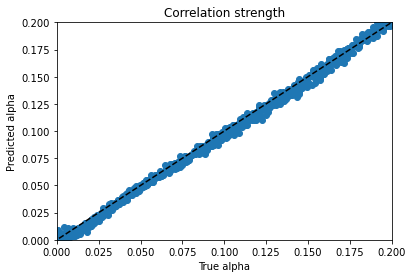

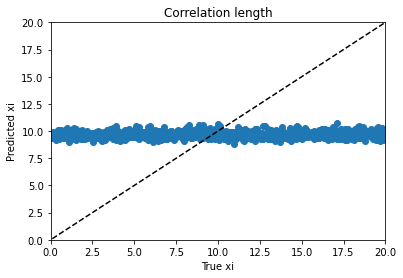

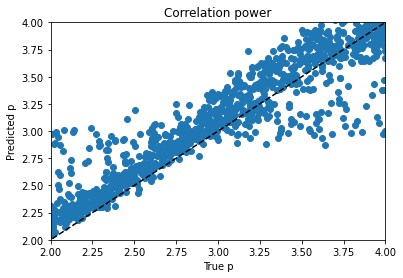

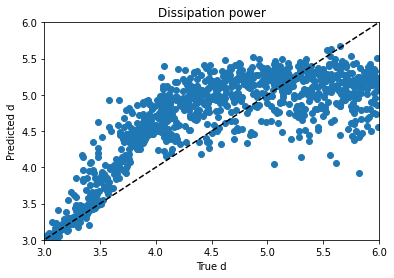

In [116]:
plt.scatter(mat_test[:,0],mat3_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat3_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat3_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat3_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

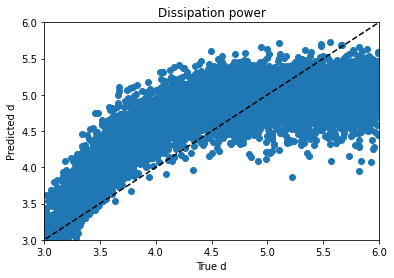

In [56]:
plt.figure()
plt.scatter(mat_train[:,3],mat3_train_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

This seems like the obvious place to look for improvement. I'm boggled why this parameter can't be trained better, but I don't know enough about neural networks to identify a solution. Fortunately there are six hours to go.

Dropout is a way to deal with overfitting, and that's not our problem here. Train and test errors are very close, this plot of the problem target looks very similar for both train and test data.

Well, first, let's see if I can sharpen up the model creation a bit.

## Model 4

In [66]:
def build_model2(hp):
    inputs = Input(shape=(N,))
    x = Dense(units=512,activation='relu')(inputs)
    y = Dense(
        units = hp.Int('units',min_value=16,max_value=512,step=124),
        activation='relu'
    )(x)
    outputs = Dense(4)(y)
    model = Model(inputs, outputs)
    opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
    model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
    return model

In [67]:
tuner2 = kerastuner.tuners.Hyperband(
        build_model2,
        objective='mean_squared_error',
        max_epochs=100,
        executions_per_trial=2,
        directory='keras_tune2'
)

In [68]:
print('Starting Tuning')
tuner2.search(M_train,scaler.transform(mat_train),
             validation_data=(M_test,mat_test))
print('Finished Tuning')

Trial 5 Complete [00h 00m 08s]
mean_squared_error: 0.0581966508179903

Best mean_squared_error So Far: 0.05451534874737263
Total elapsed time: 00h 00m 54s
INFO:tensorflow:Oracle triggered exit
Finished Tuning


In [72]:
tuned_models2 = tuner2.get_best_models(num_models=5)

In [73]:
for tm in tuned_models2:
    print(tm.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               461312    
_________________________________________________________________
dense_1 (Dense)              (None, 264)               135432    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1060      
Total params: 597,804
Trainable params: 597,804
Non-trainable params: 0
_________________________________________________________________
None
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_____________________

In [74]:
model4 = tuned_models2[0]
mat4_train_predict = scaler.inverse_transform(model4.predict(M_train))
mat4_predict = scaler.inverse_transform(model4.predict(M_test))
print('Training score for model ',weight_mse(mat_train,mat4_train_predict))
print('Test score for model ',weight_mse(mat_test,mat4_predict))

Training score for model  0.20658943634673155
Test score for model  0.20357652644143265


For whatever reason the tuner quit early, long before it had tried doing 100 epochs. Let's manually train a model with 512 and 256 neurons in the two hidden layers.

## Model 5

In [79]:
input5_layer = Input(shape=(N,))
layer51 = Dense(512,activation='relu')(input5_layer)
layer52 = Dense(256,activation='relu')(layer51)
layer53 = Dense(4)(layer52)

model5 = Model(name='Model_5',inputs=input5_layer, outputs=layer53)
model5.summary()

Model: "Model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               461312    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 593,668
Trainable params: 593,668
Non-trainable params: 0
_________________________________________________________________


In [80]:
opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
model5.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [81]:
n_epochs = 40
n_batch = 10
# transform the target so that mse is equivalent to the appropriate metric
print('Starting Training')
model5.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 5s 5ms/step - loss: 0.0600 - mean_squared_error: 0.0600
Epoch 2/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 3/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 4/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 5/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453
Epoch 6/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0436 - mean_squared_error: 0.0436
Epoch 7/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0429 - mean_squared_error: 0.0429
Epoch 8/40
900/900 [==============================] - 5s 5ms/step - loss: 0.0417 - mean_squared_error: 0.0417
Epoch 9/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0413 - mean_squared_error:

In [82]:
mat5_train_predict = scaler.inverse_transform(model5.predict(M_train,batch_size=n_batch))
mat5_predict = scaler.inverse_transform(model5.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat5_train_predict))
print('Test score for model ',weight_mse(mat_test,mat5_predict))

Training score for model  0.12937710353814633
Test score for model  0.12651953377293923


In [121]:
mat_sub = scaler.inverse_transform(model5.predict(M_train))

NameError: name 'model5' is not defined

Let's plot that.

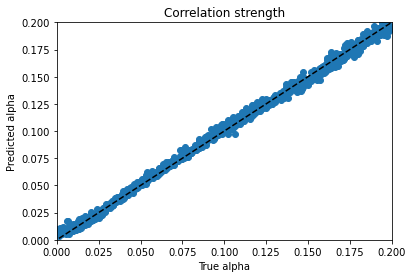

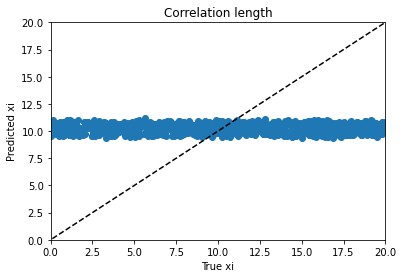

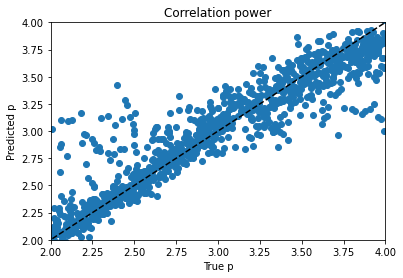

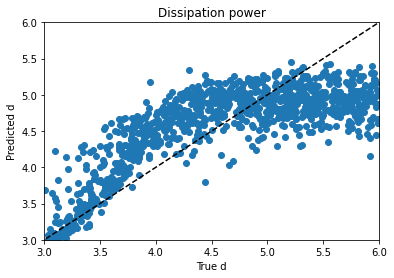

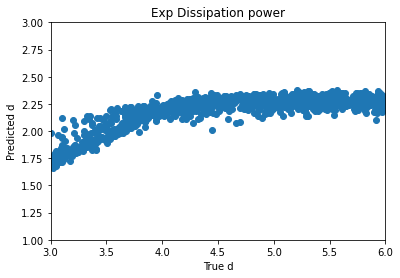

In [122]:
plt.scatter(mat_test[:,0],mat5_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat5_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat5_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat5_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Model 6
I don't see an easier way to do this. I've worked damn hard this week and my brain is going numb.

Well, I mean I *do* see a better way, but not an easier way. This is a crude hack; I will go back and see if I can split the output neurons and put an exponential activation on the neuron that reports $d$.

In [75]:
mat_train_tr = mat_train.copy()

In [76]:
mat_train_tr is mat_train

False

In [77]:
mat_train_tr[:,3]=np.log(mat_train[:,3])

In [78]:
mat_train[:3,:]

array([[ 0.11501314,  8.01074766,  2.53666314,  4.05991278],
       [ 0.174987  , 11.64201446,  3.68769076,  4.24813948],
       [ 0.10317918,  1.88649881,  2.31492155,  4.6918782 ]])

In [79]:
mat_train_tr[:3,:]

array([[ 0.11501314,  8.01074766,  2.53666314,  1.40116149],
       [ 0.174987  , 11.64201446,  3.68769076,  1.44648112],
       [ 0.10317918,  1.88649881,  2.31492155,  1.54583297]])

In [80]:
mat_test_tr = mat_test.copy()
mat_test_tr[:,3]=np.log(mat_test[:,3])

In [81]:
trscaler=MinMaxScaler()
trscaler.fit(mat_train_tr)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [92]:
input6_layer = Input(shape=(N,))
layer61 = Dense(512,activation='relu')(input6_layer)
layer62 = Dense(256,activation='relu')(layer61)
layer63 = Dense(4)(layer62)

model6 = Model(name='Model_6',inputs=input6_layer, outputs=layer63)
model6.summary()

Model: "Model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               461312    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 1028      
Total params: 593,668
Trainable params: 593,668
Non-trainable params: 0
_________________________________________________________________


In [93]:
#opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
model6.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [95]:
n_epochs = 40
n_batch = 10
# transform the target to avoid 
print('Starting Training')
model6.fit(M_train,trscaler.transform(mat_train_tr),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0586 - mean_squared_error: 0.0586
Epoch 2/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 3/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 4/40
900/900 [==============================] - 5s 6ms/step - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 5/40
900/900 [==============================] - 5s 6ms/step - loss: 0.0436 - mean_squared_error: 0.0436
Epoch 6/40
900/900 [==============================] - 5s 5ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 7/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 8/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0389 - mean_squared_error: 0.0389
Epoch 9/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0392 - mean_squared_error:

In [96]:
mat6_train_predict = trscaler.inverse_transform(model6.predict(M_train,batch_size=n_batch))
mat6_train_predict[:,3]=np.exp(mat6_train_predict[:,3])
mat6_predict = trscaler.inverse_transform(model6.predict(M_test,batch_size=n_batch))
mat6_predict[:,3]=np.exp(mat6_predict[:,3])
print('Training score for model ',weight_mse(mat_train,mat6_train_predict))
print('Test score for model ',weight_mse(mat_test,mat6_predict))

Training score for model  0.1545942497902711
Test score for model  0.15046690286594983


Let's plot that.

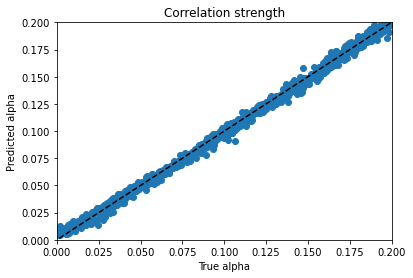

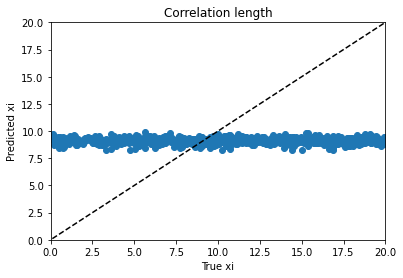

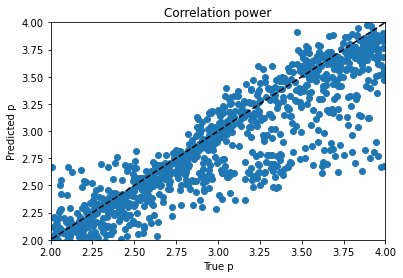

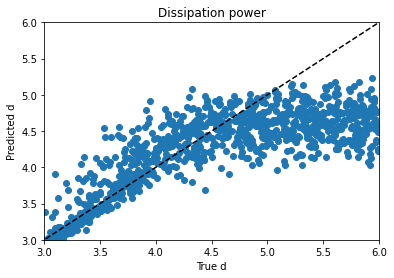

In [97]:
plt.scatter(mat_test[:,0],mat6_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat6_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat6_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat6_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Model 7
Wherein we first of all try to do things the right way, by splitting $d$ from the other variables and giving it a distinct activation function, then track down what in God's name that function might be.

In [24]:
input7_layer = Input(shape=(N,))
layer71 = Dense(512,activation='relu')(input7_layer)
layer72 = Dense(256,activation='relu')(layer71)
layer73a = Dense(3)(layer72)
layer73b = Dense(1,activation='tanh')(layer72)
layer74 = Concatenate()([layer73a,layer73b])

model7 = Model(name='Model_7',inputs=input7_layer, outputs=layer74)
model7.summary()

Model: "Model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 900)]        0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 512)          461312      input_6[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 256)          131328      dense_20[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 3)            771         dense_21[0][0]                   
____________________________________________________________________________________________

In [25]:
opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
model7.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [26]:
n_epochs = 40
n_batch = 10
# transform the target to scale features to [0,1]...not sure how this will affect d
print('Starting Training')
model7.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 5s 5ms/step - loss: 0.0598 - mean_squared_error: 0.0598
Epoch 2/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 3/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 4/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 5/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0451 - mean_squared_error: 0.0451
Epoch 6/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0436 - mean_squared_error: 0.0436
Epoch 7/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 8/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0413 - mean_squared_error: 0.0413
Epoch 9/40
900/900 [==============================] - 5s 5ms/step - loss: 0.0409 - mean_squared_error:

In [27]:
mat7_train_predict = scaler.inverse_transform(model7.predict(M_train,batch_size=n_batch))
mat7_predict = scaler.inverse_transform(model7.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat7_train_predict))
print('Test score for model ',weight_mse(mat_test,mat7_predict))

Training score for model  0.13344670118089058
Test score for model  0.1389222410674627


Let's plot that.

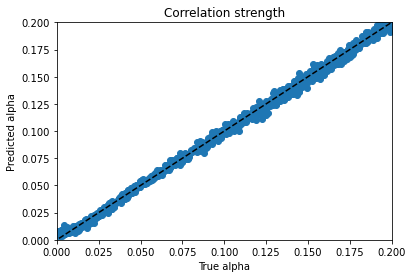

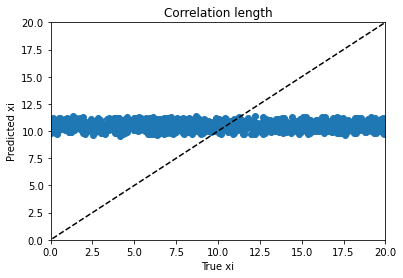

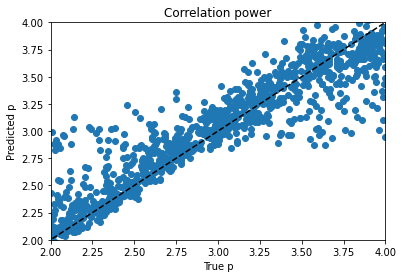

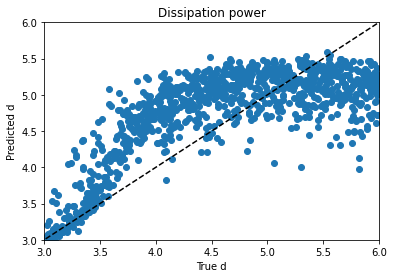

In [28]:
plt.scatter(mat_test[:,0],mat7_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat7_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat7_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat7_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Model 8
You know what, let's just see if we can tune (a) model(s) specifically to deal with our problem child / children (yes, I'm looking at you, too, correlation length). They tell me that neural networks are universal function approximators; if I give each variable its own network I should get bloody somewhere.

Just building a new model specifically for $d$ didn't do much, so I started playing with activation functions in the interior.

###### Post-competition strategy
Over the weekend I considered whether mean absolute error might result in a model that predicts the predictable part of the curve better and allows the unpredictable part to flare out.

In [16]:
def build_model3(hp):
    inputs = Input(shape=(N,))
    x = Dense(
        units = hp.Choice('layer1',values=[64,256,1024]),
        activation='elu'
    )(inputs)
    y = Dense(
        units = hp.Choice('layer2',values=[16,64,256]),
        activation='elu'
    )(x)
    outputs = Dense(1)(y)
    model = Model(inputs, outputs)
    opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
    model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
    return model

In [ ]:
opt = keras.optimizers.SGD(
        hp.Choice('learning_rate',
                 values=[0.01,0.005,0.001]),
        hp.Choice('momentum',
                 values=[0.67,0.9,0.95])
    )

In [17]:
tuner3 = kerastuner.tuners.Hyperband(
        build_model3,
        objective='mean_absolute_error',
        max_epochs=100,
        executions_per_trial=2,
        directory='post_model_d'
)

INFO:tensorflow:Reloading Oracle from existing project post_model_d/untitled_project/oracle.json


In [18]:
scd = MinMaxScaler()
scd.fit(mat_info[:,3].reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
print('Starting Tuning')
tuner3.search(M_train,scd.transform(mat_train)[:,3])
print('Finished Tuning')

Trial 9 Complete [00h 00m 05s]
mean_absolute_error: 0.24674198031425476

Best mean_absolute_error So Far: 0.24350889027118683
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit
Finished Tuning


In [20]:
tuner3.results_summary()

Results summary
Results in post_model_d/untitled_project
Showing 10 best trials
Objective(name='mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
layer1: 1024
layer2: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.24350889027118683
Trial summary
Hyperparameters:
layer1: 1024
layer2: 16
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.24407228827476501
Trial summary
Hyperparameters:
layer1: 256
layer2: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.24511373043060303
Trial summary
Hyperparameters:
layer1: 1024
layer2: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.24663963913917542
Trial summary
Hyperparameters:
layer1: 64
layer2: 16
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.24669626355171204
Trial summary
Hyperparameters:
layer1: 64
layer2: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bra

In [22]:
model8 = tuner3.get_best_models(num_models=5)[4]

In [23]:
model8.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 942)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                60352     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 61,409
Trainable params: 61,409
Non-trainable params: 0
_________________________________________________________________


In [24]:
# we can make it stronger... we have the technology
# we are going to PUMP you UP
n_epochs = 40
n_batch = 10
# transform the target to scale features to [0,1]...not sure how this will affect d
print('Starting Training')
model8.fit(M_train,scd.transform(mat_train[:,3].reshape(-1,1)),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2465 - mean_absolute_error: 0.2465
Epoch 2/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2409 - mean_absolute_error: 0.2409
Epoch 3/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2306 - mean_absolute_error: 0.2306
Epoch 4/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2235 - mean_absolute_error: 0.2235
Epoch 5/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2197 - mean_absolute_error: 0.2197
Epoch 6/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2206 - mean_absolute_error: 0.2206
Epoch 7/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2080 - mean_absolute_error: 0.2080
Epoch 8/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2106 - mean_absolute_error: 0.2106
Epoch 9/40
900/900 [==============================] - 2s 2ms/step - loss: 0.2061 - mean_absolu

In [25]:
mat8_train_predict = scd.inverse_transform(model8.predict(M_train))
mat8_predict = scd.inverse_transform(model8.predict(M_test))
print('Training score for model ',sklearn.metrics.mean_squared_error(mat_train[:,3],mat8_train_predict)/9)
print('Test score for model ',sklearn.metrics.mean_squared_error(mat_test[:,3],mat8_predict)/9)

Training score for model  0.04498311937029458
Test score for model  0.04428550541659765


Let's plot that.

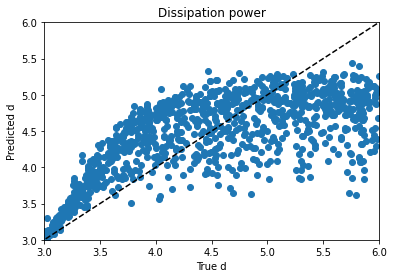

In [26]:
plt.figure()
plt.scatter(mat_test[:,3],mat8_predict);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

I can't believe this. What is forcing these models to behave this way that isn't addressed by the stuff I've tried? Basically it looks like the behavior below $d = 4$ can be predicted and the behavior above cannot.

## Model 9
In which I draw sword against $\xi$.

In [58]:
def build_model4(hp):
    inputs = Input(shape=(N,))
    x = Dense(
        units = hp.Choice('layer1',values=[64,256,1024]),
        activation='elu'
    )(inputs)
    y = Dense(
        units = hp.Choice('layer2',values=[16,64,256]),
        activation='elu'
    )(x)
    outputs = Dense(1)(y)
    model = Model(inputs, outputs)
    opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
    model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
    return model

In [59]:
tuner4 = kerastuner.tuners.Hyperband(
        build_model4,
        objective='mean_squared_error',
        max_epochs=100,
        executions_per_trial=2,
        directory='keras_tune4'
)

In [60]:
scxi = MinMaxScaler()
scxi.fit(mat_info[:,1].reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [61]:
print('Starting Tuning')
tuner4.search(M_train,scxi.transform(mat_train)[:,1])
print('Finished Tuning')

Trial 9 Complete [00h 00m 15s]
mean_squared_error: 0.08622241765260696

Best mean_squared_error So Far: 0.08592872321605682
Total elapsed time: 00h 01m 19s
INFO:tensorflow:Oracle triggered exit
Finished Tuning


In [62]:
tuner4.results_summary()

Results summary
Results in keras_tune4/untitled_project
Showing 10 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
layer1: 64
layer2: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.08592872321605682
Trial summary
Hyperparameters:
layer1: 1024
layer2: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.08620576187968254
Trial summary
Hyperparameters:
layer1: 1024
layer2: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.08622241765260696
Trial summary
Hyperparameters:
layer1: 256
layer2: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.08670295402407646
Trial summary
Hyperparameters:
layer1: 256
layer2: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.08680764585733414
Trial summary
Hyperparameters:
layer1: 64
layer2: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/brack

In [63]:
model9 = tuner4.get_best_models(num_models=1)[0]

In [64]:
model9.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                57664     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 74,561
Trainable params: 74,561
Non-trainable params: 0
_________________________________________________________________


In [65]:
n_epochs = 40
n_batch = 10
# transform the target to scale features to [0,1]
print('Starting Training')
model8.fit(M_train,scxi.transform(mat_train[:,1].reshape(-1,1)),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 2/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0882 - mean_squared_error: 0.0882
Epoch 3/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 4/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0875 - mean_squared_error: 0.0875
Epoch 5/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 6/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0872 - mean_squared_error: 0.0872
Epoch 7/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0875 - mean_squared_error: 0.0875
Epoch 8/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0867 - mean_squared_error: 0.0867
Epoch 9/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0878 - mean_squared_error:

In [68]:
mat9_train_predict = scxi.inverse_transform(model9.predict(M_train))
mat9_predict = scxi.inverse_transform(model9.predict(M_test))
print('Training score for model ',sklearn.metrics.mean_squared_error(mat_train[:,1],mat9_train_predict)/400)
print('Test score for model ',sklearn.metrics.mean_squared_error(mat_test[:,1],mat9_predict)/400)

Training score for model  0.08570692378965893
Test score for model  0.0857066459535306


Let's plot that.

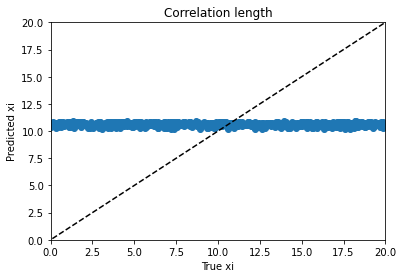

In [69]:
plt.figure()
plt.scatter(mat_test[:,1],mat9_predict);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20]);
plt.title("Correlation length");

Training noise. It's a peck of fun.

So what else am I going to try in this last couple of hours?

Thinking: $d$ is related to the time constant $T_d = k 10^{-d/2}$. Once $d$ gets above 4, there is barely any change in the plots and therefore barely any information in them that the neural nets can extract to predict higher values of $d$... that's where I stand conceptually at the moment, looking at the data. Increases in $d$ are decreases in $T_d$. Are the low $d$ cases the ones with significant residual magnetic activity at time $\tau$ and the high $d$ ones the "standard" cases where the spins have spread out and the 180 pulse starts them back toward reassembling into the echo?

In that case, given that I only have two hours to tie this up and send you something, I could do something rather rash: train on just the entries with $d <=4$.

The other possibility is to go back to my crude hack model 6 tactic where I bruted a log transform onto the data and apply that to a model with separated paths for $d$ and the other variables. Maybe I also see what happens if I push $\xi$ off into its own internal tree. I tried to apply a log function as an activation for $d$ in model 7, but the loss functions could not be evaluated... bizarrely, the model tried to train itself, but the losses were all nan and the model could not be evaluated afterward.

## Model 10

In [71]:
def build_model10(hp):
    inputs = Input(shape=(N,))
    x = Dense(
        units = hp.Choice('layer1',values=[16,64,256]),
        activation='elu'
    )(inputs)
    yd = Dense(
        units = hp.Choice('layer2d',values=[8,32,128]),
        activation='elu'
    )(x)
    yxi = Dense(
        units = 4,
        activation='elu'
    )(x)
    yap = Dense(
        units = hp.Choice('layer2ap',values=[16,64,256]),
        activation='elu'
    )(x)
    zd = Dense(
        units = hp.Choice('layer3d',values=[4,32]),
        activation='elu'
    )(yd)
    zxi = Dense(
        units = 2,
        activation='elu'
    )(yxi)
    zap = Dense(
        units = hp.Choice('layer3ap',values=[8,64]),
        activation='elu'
    )(yap)
    outd = Dense(1)(zd)
    outxi = Dense(1)(zxi)
    outa = Dense(1)(zap)
    outp = Dense(1)(zap)
    outputs = Concatenate()([outa,outxi,outp,outd])
    model = Model(inputs, outputs)
    opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
    model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
    return model

In [73]:
tuner10 = kerastuner.tuners.Hyperband(
        build_model10,
        objective='mean_squared_error',
        max_epochs=33,
        executions_per_trial=2,
        directory='keras_tune10'
)

I mistakenly used `scaler` instead of `trscaler` in the next cell. I will not have time to go back and rerun the tuning, but hopefully the model structure it discovers will work.

In [82]:
print('Starting Tuning')
tuner10.search(M_train,scaler.transform(mat_train_tr))
print('Finished Tuning')

Trial 90 Complete [00h 01m 06s]
mean_squared_error: 0.030391693115234375

Best mean_squared_error So Far: 0.029421127401292324
Total elapsed time: 00h 30m 13s
INFO:tensorflow:Oracle triggered exit
Finished Tuning


In [83]:
tuner10.results_summary()

Results summary
Results in keras_tune10/untitled_project
Showing 10 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
layer1: 64
layer2d: 32
layer2ap: 16
layer3d: 4
layer3ap: 64
tuner/epochs: 33
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.029421127401292324
Trial summary
Hyperparameters:
layer1: 256
layer2d: 32
layer2ap: 256
layer3d: 32
layer3ap: 8
tuner/epochs: 33
tuner/initial_epoch: 11
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: eff667eff5fff4be28e80c6686a3b2a3
Score: 0.029459443874657154
Trial summary
Hyperparameters:
layer1: 256
layer2d: 8
layer2ap: 64
layer3d: 32
layer3ap: 8
tuner/epochs: 33
tuner/initial_epoch: 11
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 83edd46611e2c066b074d6f79b5a74dc
Score: 0.029687143862247467
Trial summary
Hyperparameters:
layer1: 256
layer2d: 128
layer2ap: 16
layer3d: 4
layer3ap: 8
tuner/epochs: 33
tuner/initial_epoch: 11
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: a28031d50c

In [88]:
model10 = tuner10.get_best_models(num_models=1)[0]
model10.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 900)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           57664       input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           1040        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            260         dense[0][0]                      
_______________________________________________________________________________________

In [92]:
# we can make it stronger... we have the technology
# we are going to PUMP you UP
n_epochs = 40
n_batch = 10
# transform the target to scale features to [0,1]...with the mistake that I used
# scaler instead of trscaler above, probably no time to fix it now, but maybe, we'll see
print('Starting Training')
model10.fit(M_train,scaler.transform(mat_train_tr),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0306 - mean_squared_error: 0.0306
Epoch 2/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 3/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 4/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 5/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0295 - mean_squared_error: 0.0295
Epoch 6/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 7/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0288 - mean_squared_error: 0.0288
Epoch 8/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 9/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0292 - mean_squared_error:

In [93]:
mat10_train_predict = scaler.inverse_transform(model10.predict(M_train,batch_size=n_batch))
mat10_train_predict[:,3]=np.exp(mat10_train_predict[:,3])
mat10_predict = scaler.inverse_transform(model10.predict(M_test,batch_size=n_batch))
mat10_predict[:,3]=np.exp(mat10_predict[:,3])
print('Training score for model ',weight_mse(mat_train,mat10_train_predict))
print('Test score for model ',weight_mse(mat_test,mat10_predict))

Training score for model  0.1518837705316063
Test score for model  0.15609987081435087


Let's plot that.

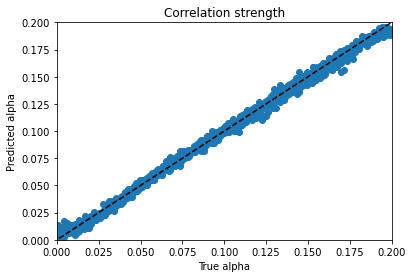

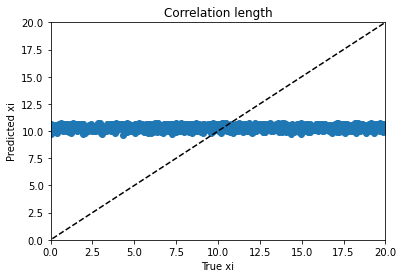

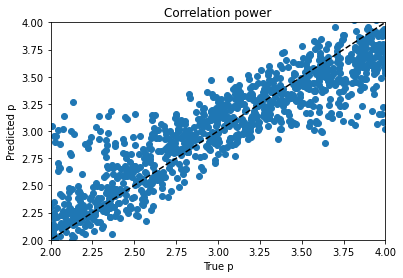

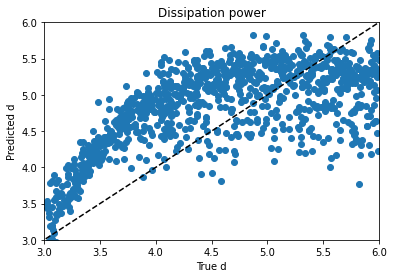

In [94]:
plt.scatter(mat_test[:,0],mat10_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat10_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat10_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat10_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Model 12
in greater haste

In [110]:
model12 = keras.models.clone_model(model10)

In [111]:
model12.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 900)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           57664       input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           1040        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            260         dense[0][0]                      
_______________________________________________________________________________________

In [112]:
opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
model12.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
n_epochs = 40
n_batch = 10
# transform the target to scale features to [0,1]...not not effing with log transform
# just using the bigger structure
print('Starting Training')
model12.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0613 - mean_squared_error: 0.0613
Epoch 2/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0533 - mean_squared_error: 0.0533
Epoch 3/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0510 - mean_squared_error: 0.0510
Epoch 4/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 5/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 6/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 7/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0473 - mean_squared_error: 0.0473
Epoch 8/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0472 - mean_squared_error: 0.0472
Epoch 9/40
900/900 [==============================] - 2s 2ms/step - loss: 0.0467 - mean_squared_error:

In [113]:
mat12_train_predict = scaler.inverse_transform(model12.predict(M_train,batch_size=n_batch))
mat12_predict = scaler.inverse_transform(model12.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat12_train_predict))
print('Test score for model ',weight_mse(mat_test,mat12_predict))

Training score for model  0.14520216390627058
Test score for model  0.149538385748348


Let's plot that.

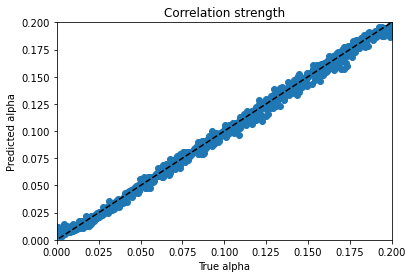

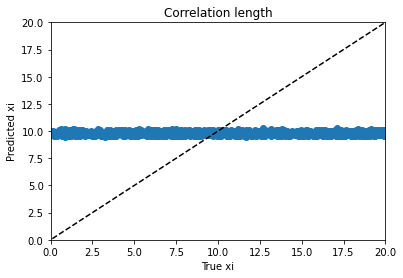

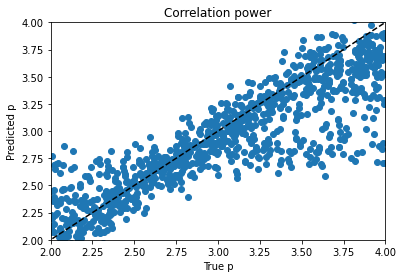

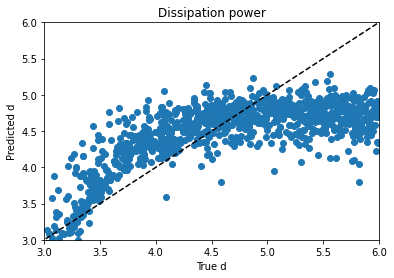

In [114]:
plt.scatter(mat_test[:,0],mat12_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat12_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat12_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat12_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Model 13
redo of model 5

In [12]:
input13_layer = Input(shape=(N,))
layer131 = Dense(512,activation='relu')(input13_layer)
layer132 = Dense(256,activation='relu')(layer131)
layer133 = Dense(4)(layer132)

model13 = Model(name='Model_13',inputs=input13_layer, outputs=layer133)
model13.summary()

Model: "Model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 942)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               482816    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 615,172
Trainable params: 615,172
Non-trainable params: 0
_________________________________________________________________


In [13]:
opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
model13.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [14]:
n_epochs = 40
n_batch = 10
# transform the target so that mse is equivalent to the appropriate metric
print('Starting Training')
model13.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 6s 7ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 2/40
900/900 [==============================] - 6s 6ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 3/40
900/900 [==============================] - 5s 6ms/step - loss: 0.0480 - mean_squared_error: 0.0480
Epoch 4/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 5/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 6/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0432 - mean_squared_error: 0.0432
Epoch 7/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0420 - mean_squared_error: 0.0420
Epoch 8/40
900/900 [==============================] - 4s 5ms/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 9/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0409 - mean_squared_error:

In [15]:
mat13_train_predict = scaler.inverse_transform(model13.predict(M_train,batch_size=n_batch))
mat13_predict = scaler.inverse_transform(model13.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat13_train_predict))
print('Test score for model ',weight_mse(mat_test,mat13_predict))

Training score for model  0.12976466189058466
Test score for model  0.1333459706907496


Let's plot that.

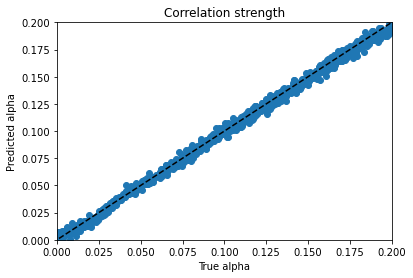

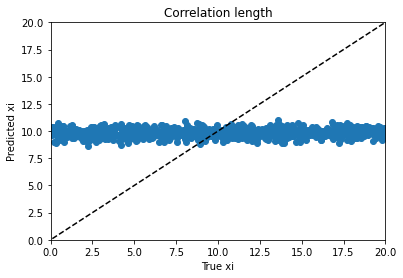

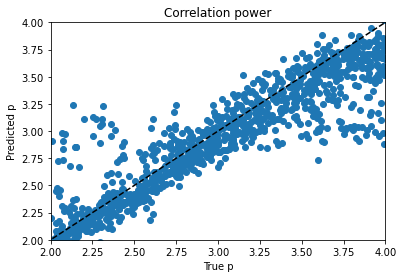

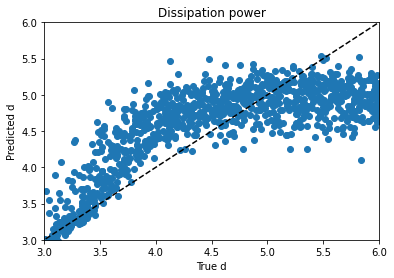

In [17]:
plt.scatter(mat_test[:,0],mat13_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat13_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat13_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat13_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Model 14
20 minutes to go and the frap ray cannon, I mean cells to produce submission, are all warmed up

In [126]:
model14 = keras.models.clone_model(tuner10.get_best_models(num_models=2)[1])
model14.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 900)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          230656      input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            1028        dense[0][0]                      
_______________________________________________________________________________________

In [127]:
opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.95)
model14.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
n_epochs = 40
n_batch = 10
# transform the target to scale features to [0,1]...not effing with log transform
# just using the even bigger structure from tuner10 #2
print('Starting Training')
model14.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0587 - mean_squared_error: 0.0587
Epoch 2/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 3/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 4/40
900/900 [==============================] - 3s 4ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 5/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0474 - mean_squared_error: 0.0474
Epoch 6/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0471 - mean_squared_error: 0.0471
Epoch 7/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0458 - mean_squared_error: 0.0458
Epoch 8/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0442 - mean_squared_error: 0.0442
Epoch 9/40
900/900 [==============================] - 4s 4ms/step - loss: 0.0438 - mean_squared_error:

In [128]:
mat14_train_predict = scaler.inverse_transform(model14.predict(M_train,batch_size=n_batch))
mat14_predict = scaler.inverse_transform(model14.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat14_train_predict))
print('Test score for model ',weight_mse(mat_test,mat14_predict))

Training score for model  0.1416714822112891
Test score for model  0.1466672355807766


Let's plot that.

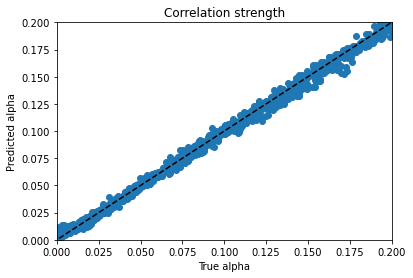

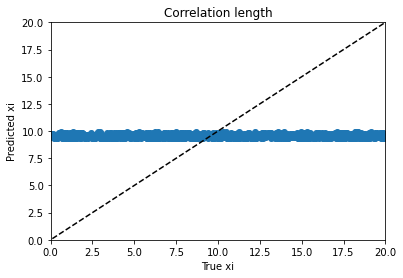

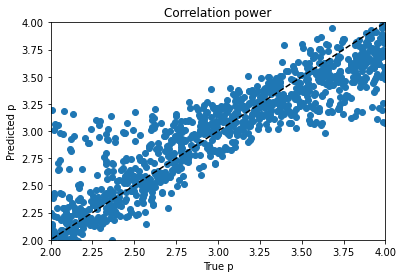

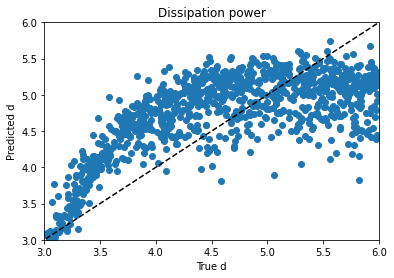

In [129]:
plt.scatter(mat_test[:,0],mat14_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat14_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat14_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat14_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");